# Proyecto Analisis de Datos - Limpieza

### Modelo de _Forecast_ de flujo de clientes en una empresa en Chile

**Autor**

- Adolfo Fuentes Jofré


**Colaboradores**

- Juan Francisco Calderon
- Catalina Murua

## Introducción

### Problema o necesidad

Las operaciones y la planificación de demanda responde a factores que son conocidos pero también a factores altamente variables dependiendo de la estacionalidad de la temporada del año, día de la semana y horario del día. La toma de decisiones en temas de logística, adquisiciones, operaciones de RRHH y otros aspectos deben estar basadas en datos y predicciones deben considerar el historial de la demanda y el comportamiento estacional de los usuarios  el cual es variable en el tiempo.
Se utilizará un dataset del flujo de clientes en una empresa Chilena durante todo lo que va del año 2022, identificaremos patrones de uso y trataremos de implementar predicciones respecto flujo de clientes a futuro.

### Dataset

Base  de Datos Interna de la compañía que registra la cantidad de usuarios en un momento especifico del día. La BBDD tiene 347.863 registros.


## Analisis Exploratorio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import researchpy as rp
import scipy.stats as stats
from scipy.stats import f_oneway
import seaborn
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from Funciones.Funciones_feriados_semana import Feriado, Diaantesdeferiado, semana_del_mes

### BBDD a estudiar

Se importa la BBDD utilizada por una compañía para monitorear el flujo de clientes.

In [2]:
df=pd.read_csv('Data/raw/Flujo.csv', sep=';')
df

,store_id,Fecha,Fecha_Timestamp,Hora,Minutos,Dia,Semana,Año,Mes,Cantidad
0,9,16-03-2022,2022-03-17 02:30:00.913,2,30,3,12,2022,3,1
1,11,28-03-2022,2022-03-28 21:00:01.883,21,0,1,14,2022,3,14
2,7,07-02-2022,2022-02-08 00:00:00.720,0,0,1,7,2022,2,1
3,1,28-01-2022,2022-01-28 20:00:01.960,20,0,5,5,2022,1,28
4,7,20-08-2022,2022-08-20 13:30:00.870,13,30,6,34,2022,8,1
...,...,...,...,...,...,...,...,...,...,...
347858,9,16-03-2022,2022-03-16 17:00:01.143,17,0,3,12,2022,3,5
347859,10,29-04-2022,2022-04-29 14:30:00.447,14,30,5,18,2022,4,13
347860,10,27-03-2022,2022-03-28 02:00:00.467,2,0,7,13,2022,3,9
347861,1,09-04-2022,2022-04-09 19:00:00.487,19,0,6,15,2022,4,3


**Filtraremos solo datos del año 2022**

In [3]:
df=df[df['Año']==2022]
df

,store_id,Fecha,Fecha_Timestamp,Hora,Minutos,Dia,Semana,Año,Mes,Cantidad
0,9,16-03-2022,2022-03-17 02:30:00.913,2,30,3,12,2022,3,1
1,11,28-03-2022,2022-03-28 21:00:01.883,21,0,1,14,2022,3,14
2,7,07-02-2022,2022-02-08 00:00:00.720,0,0,1,7,2022,2,1
3,1,28-01-2022,2022-01-28 20:00:01.960,20,0,5,5,2022,1,28
4,7,20-08-2022,2022-08-20 13:30:00.870,13,30,6,34,2022,8,1
...,...,...,...,...,...,...,...,...,...,...
347858,9,16-03-2022,2022-03-16 17:00:01.143,17,0,3,12,2022,3,5
347859,10,29-04-2022,2022-04-29 14:30:00.447,14,30,5,18,2022,4,13
347860,10,27-03-2022,2022-03-28 02:00:00.467,2,0,7,13,2022,3,9
347861,1,09-04-2022,2022-04-09 19:00:00.487,19,0,6,15,2022,4,3


**Veremos que unidad (local) presenta una mayor cantidad de registros por completitud de datos, de modo de elegir un local con la mayor granularidad posible de datos**

In [4]:
df.groupby(['store_id'])['store_id'].count()

store_id
1     46471
3     44346
4     34032
6     40849
7     48625
8     20302
9     38500
10    48077
11    26247
Name: store_id, dtype: int64

**Se filtra para la store # 7 debido a que es la que presenta mayor cantidad de registros**

In [5]:
df_filtro=df[df['store_id']==7]
df_filtro

,store_id,Fecha,Fecha_Timestamp,Hora,Minutos,Dia,Semana,Año,Mes,Cantidad
2,7,07-02-2022,2022-02-08 00:00:00.720,0,0,1,7,2022,2,1
4,7,20-08-2022,2022-08-20 13:30:00.870,13,30,6,34,2022,8,1
5,7,14-02-2022,2022-02-14 17:00:00.263,17,0,1,8,2022,2,8
29,7,02-06-2022,2022-06-02 11:30:00.260,11,30,4,23,2022,6,1
49,7,15-06-2022,2022-06-16 00:00:00.230,0,0,3,25,2022,6,16
...,...,...,...,...,...,...,...,...,...,...
347814,7,10-09-2022,2022-09-11 03:30:01.003,3,30,6,37,2022,9,14
347829,7,01-02-2022,2022-02-01 13:30:00.650,13,30,2,6,2022,2,2
347835,7,26-05-2022,2022-05-26 18:00:00.267,18,0,4,22,2022,5,15
347841,7,17-07-2022,2022-07-17 15:30:00.357,15,30,7,29,2022,7,4


### Prueba de Concepto

**Para poder explorar de mejor manera el dataset se filtra dos dias, el 28 y 29 de enero que corresponde a dias viernes y sabado**

Nuestra creencia _a priori_ basada en la observación **sin acceso a datos** es que el consumo en los locales de la Compañía sea significativamente mayor durante los fines de semana y en horario nocturno. Así, esta primera prueba de concepto consiste en analizar numérica y visualmente un set de datos extraído del set total y que corresponde a la fecha señalada.

In [6]:
df_filtro_dia=df_filtro[(df_filtro['Fecha']=='28-01-2022')|(df_filtro['Fecha']=='29-01-2022')]
df_filtro_dia.head()

,store_id,Fecha,Fecha_Timestamp,Hora,Minutos,Dia,Semana,Año,Mes,Cantidad
1327,7,29-01-2022,2022-01-30 02:30:00.967,2,30,6,5,2022,1,147
2732,7,29-01-2022,2022-01-29 12:30:00.357,12,30,6,5,2022,1,7
3103,7,29-01-2022,2022-01-29 20:30:00.227,20,30,6,5,2022,1,16
3419,7,29-01-2022,2022-01-29 15:00:00.717,15,0,6,5,2022,1,1
5024,7,28-01-2022,2022-01-28 18:30:00.017,18,30,5,5,2022,1,4


**Se agruparán los datos para ver cuantos registros existen por tramo horario**

Nuestra creencia es que habrá mayor consumo durante los horarios vespertinos y nocturnos que corresponden a la hora en la que la gente sale a "divertirse".

In [7]:
df_group=df_filtro_dia.groupby(["Hora"]).count()

In [8]:
df_group.head()
df_group

,store_id,Fecha,Fecha_Timestamp,Minutos,Dia,Semana,Año,Mes,Cantidad
Hora,,,,,,,,,
0,24,24,24,24,24,24,24,24,24
1,24,24,24,24,24,24,24,24,24
2,24,24,24,24,24,24,24,24,24
3,24,24,24,24,24,24,24,24,24
4,24,24,24,24,24,24,24,24,24
5,24,24,24,24,24,24,24,24,24
6,21,21,21,21,21,21,21,21,21
7,8,8,8,8,8,8,8,8,8
8,4,4,4,4,4,4,4,4,4


### Unidad de análisis

**Para acotar el analisis se utilizará una frecuencia de muestreo de cada 1 hora**

In [9]:
df_group2=df_filtro_dia.groupby(['Hora','Dia','Semana','Fecha','Mes'])['Cantidad'].sum().reset_index()
df_group2.sort_values(by=['Fecha','Hora']).reset_index(drop=True)
df_group2.head()

,Hora,Dia,Semana,Fecha,Mes,Cantidad
0,0,5,5,28-01-2022,1,557
1,0,6,5,29-01-2022,1,632
2,1,5,5,28-01-2022,1,504
3,1,6,5,29-01-2022,1,586
4,2,5,5,28-01-2022,1,433


**Creamos las variables time, date y datetime (Timestamp) las que serán utilizadas posteriormente**

In [10]:
df_group2['time'] = df_group2['Hora'].astype(str)+':00:00'

In [11]:
df_group2['date'] = pd.to_datetime(df_group2['Fecha'] , dayfirst=True)

In [12]:
df_group2['datetime'] = pd.to_datetime(df_group2['Fecha'] + ' ' + df_group2['time'])

In [13]:
df_group2_order=df_group2.sort_values(by=['datetime']).reset_index(drop=True)
df_group2_order

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime
0,0,5,5,28-01-2022,1,557,0:00:00,2022-01-28,2022-01-28 00:00:00
1,1,5,5,28-01-2022,1,504,1:00:00,2022-01-28,2022-01-28 01:00:00
2,2,5,5,28-01-2022,1,433,2:00:00,2022-01-28,2022-01-28 02:00:00
3,3,5,5,28-01-2022,1,330,3:00:00,2022-01-28,2022-01-28 03:00:00
4,4,5,5,28-01-2022,1,250,4:00:00,2022-01-28,2022-01-28 04:00:00
5,5,5,5,28-01-2022,1,141,5:00:00,2022-01-28,2022-01-28 05:00:00
6,6,5,5,28-01-2022,1,85,6:00:00,2022-01-28,2022-01-28 06:00:00
7,7,5,5,28-01-2022,1,4,7:00:00,2022-01-28,2022-01-28 07:00:00
8,8,5,5,28-01-2022,1,3,8:00:00,2022-01-28,2022-01-28 08:00:00
9,9,5,5,28-01-2022,1,3,9:00:00,2022-01-28,2022-01-28 09:00:00


**Verificaremos el tipo de dato para verificar que el timestamp este bien construido**

In [14]:
df_group2_order.dtypes

Hora                 int64
Dia                  int64
Semana               int64
Fecha               object
Mes                  int64
Cantidad             int64
time                object
date        datetime64[ns]
datetime    datetime64[ns]
dtype: object

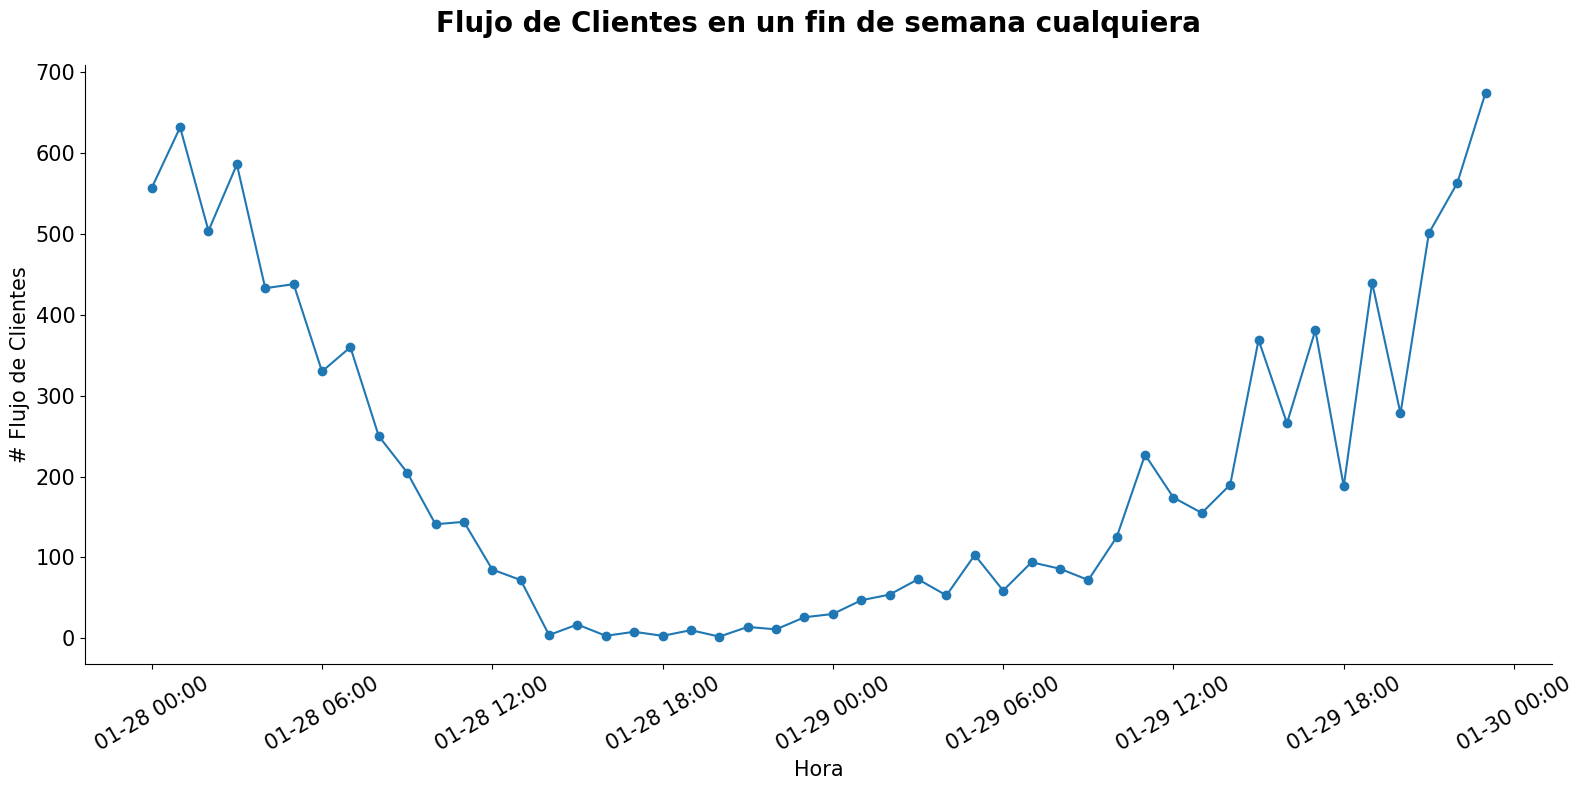

In [15]:
def hide_border(ax):
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(df_group2_order['datetime'], df_group2['Cantidad'], 'o-')
ax.set_xlabel("Hora",fontsize=15)
ax.set_ylabel("# Flujo de Clientes",fontsize=15)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
plt.setp(ax.get_xticklabels(), rotation = 30,fontsize=15)
plt.yticks(fontsize=15)
ax.set_title("Flujo de Clientes en un fin de semana cualquiera",pad=24,fontweight=700,fontsize=20)
hide_border(ax)
fig.tight_layout()

### Analisis Totalidad de los datos

**Replicaremos el mismo preprocesamiento que se utilizó para 2 dias, pero ahora para la totalidad de los registros del store 7**

In [16]:
df_group3=df_filtro.groupby(['Hora','Dia','Semana','Fecha','Mes'])['Cantidad'].sum().reset_index()

In [17]:
df_group3.sort_values(by=['Fecha','Hora']).reset_index(drop=True)

,Hora,Dia,Semana,Fecha,Mes,Cantidad
0,0,6,1,01-01-2022,1,620
1,1,6,1,01-01-2022,1,566
2,2,6,1,01-01-2022,1,472
3,3,6,1,01-01-2022,1,369
4,4,6,1,01-01-2022,1,247
...,...,...,...,...,...,...
5359,19,3,36,31-08-2022,8,164
5360,20,3,36,31-08-2022,8,265
5361,21,3,36,31-08-2022,8,391
5362,22,3,36,31-08-2022,8,533


**De esta manera tenemos una serie de tiempo con 5364 registros que corresponde todos los datos desde inicio del 2022**

In [18]:
df_group3['time'] = df_group3['Hora'].astype(str)+':00:00'

In [19]:
df_group3['date'] = pd.to_datetime(df_group3['Fecha'], dayfirst=True)

In [20]:
df_group3['datetime'] = pd.to_datetime(df_group3['Fecha'] + ' ' + df_group3['time'])

### Unidad de análisis totalidad de registros

In [21]:
df_group3_order=df_group3.sort_values(by=['datetime']).reset_index(drop=True)
df_group3_order.head(26)

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime
0,0,6,1,01-01-2022,1,620,0:00:00,2022-01-01,2022-01-01 00:00:00
1,1,6,1,01-01-2022,1,566,1:00:00,2022-01-01,2022-01-01 01:00:00
2,2,6,1,01-01-2022,1,472,2:00:00,2022-01-01,2022-01-01 02:00:00
3,3,6,1,01-01-2022,1,369,3:00:00,2022-01-01,2022-01-01 03:00:00
4,4,6,1,01-01-2022,1,247,4:00:00,2022-01-01,2022-01-01 04:00:00
5,5,6,1,01-01-2022,1,140,5:00:00,2022-01-01,2022-01-01 05:00:00
6,6,6,1,01-01-2022,1,62,6:00:00,2022-01-01,2022-01-01 06:00:00
7,7,6,1,01-01-2022,1,18,7:00:00,2022-01-01,2022-01-01 07:00:00
8,8,6,1,01-01-2022,1,2,8:00:00,2022-01-01,2022-01-01 08:00:00
9,9,6,1,01-01-2022,1,3,9:00:00,2022-01-01,2022-01-01 09:00:00


In [22]:
df_group3_order

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime
0,0,6,1,01-01-2022,1,620,0:00:00,2022-01-01,2022-01-01 00:00:00
1,1,6,1,01-01-2022,1,566,1:00:00,2022-01-01,2022-01-01 01:00:00
2,2,6,1,01-01-2022,1,472,2:00:00,2022-01-01,2022-01-01 02:00:00
3,3,6,1,01-01-2022,1,369,3:00:00,2022-01-01,2022-01-01 03:00:00
4,4,6,1,01-01-2022,1,247,4:00:00,2022-01-01,2022-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...
5359,19,1,38,12-09-2022,9,56,19:00:00,2022-09-12,2022-12-09 19:00:00
5360,20,1,38,12-09-2022,9,108,20:00:00,2022-09-12,2022-12-09 20:00:00
5361,21,1,38,12-09-2022,9,126,21:00:00,2022-09-12,2022-12-09 21:00:00
5362,22,1,38,12-09-2022,9,169,22:00:00,2022-09-12,2022-12-09 22:00:00


### Plot de toda la Serie de Tiempo

En este gráfico, a pesar de no ser amigable visualmente, se observa que hay una periodicidad en el uso de las máquinas. En general, se observan cuatro días de "bajo uso" y tres días de "alto uso". Seguiremos explorando los datos para verificar que este patrón tiene que ver con "día de semana" versus "fin de semana".

### Plot de toda la Serie de Tiempo para el mes de Enero

In [23]:
df_group3_order_enero=df_group3_order[df_group3_order['Mes']==1]
df_group3_order_enero.head()

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime
0,0,6,1,01-01-2022,1,620,0:00:00,2022-01-01,2022-01-01 00:00:00
1,1,6,1,01-01-2022,1,566,1:00:00,2022-01-01,2022-01-01 01:00:00
2,2,6,1,01-01-2022,1,472,2:00:00,2022-01-01,2022-01-01 02:00:00
3,3,6,1,01-01-2022,1,369,3:00:00,2022-01-01,2022-01-01 03:00:00
4,4,6,1,01-01-2022,1,247,4:00:00,2022-01-01,2022-01-01 04:00:00


### Plot de uso de máquinas durante la segunda semana del mes de Enero 2022

Como vimos en el gráfico anterior existe una periodicidad en el uso de máquinas que ahora vimos a nivel mes utilizando Enero 2022 como ejemplo. Veamos si, a resolución nivel semana, podemos corroborar esta periodicidad.

In [24]:
df_group3_order_enero_semana=df_group3_order_enero[df_group3_order_enero['Semana']==2]


### Plot de Dia Promedio

In [25]:
dia_promedio=df_group3_order.groupby(['Hora'])['Cantidad'].mean().reset_index()
dia_promedio

,Hora,Cantidad
0,0,336.700000
1,1,284.060000
2,2,217.530120
3,3,132.328000
4,4,74.823529
5,5,60.624242
6,6,37.163522
7,7,7.962500
8,8,7.089431
9,9,6.007143


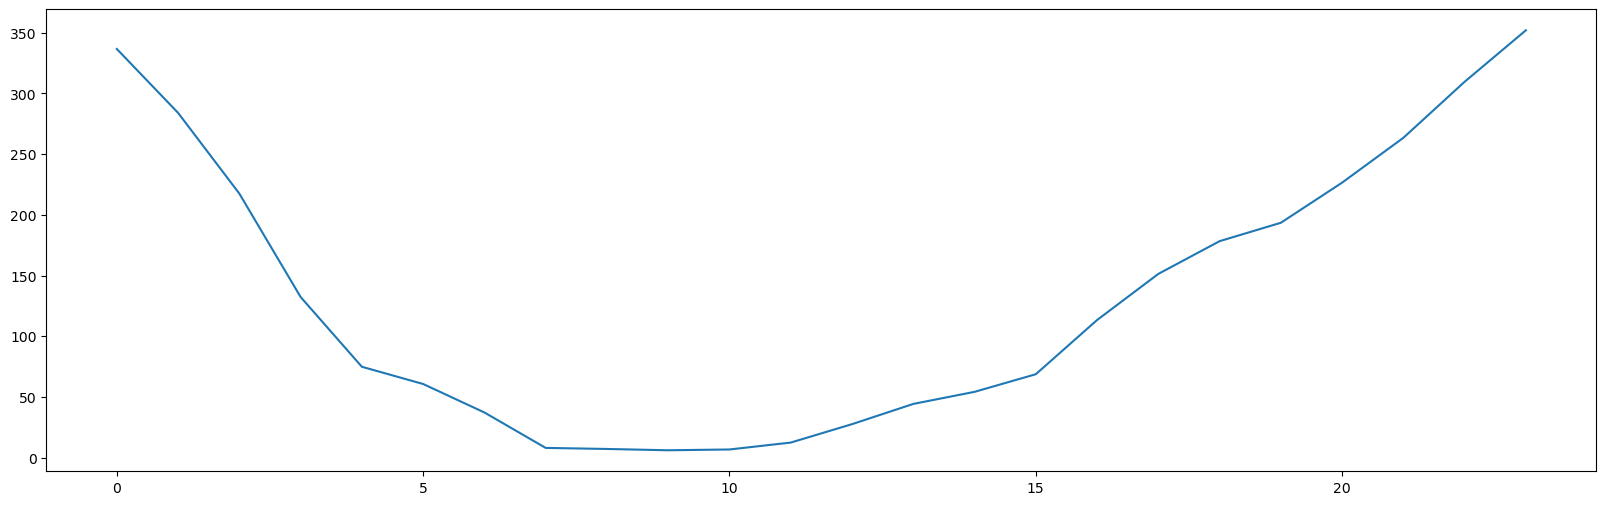

In [26]:
plt.figure(figsize=(20, 6))
plt.plot(dia_promedio['Hora'], dia_promedio['Cantidad'])

El gráfico superior, la entrega por defecto de matplotlib para un gráfico de línea sobre la función "promedio" nos muestra una tendencia. Se observa que, efectivamente, el dia comienza con un alto número de máquinas en uso y que este decae al avanzar la noche y llegar la mañana, se mantiene bajo durante la mañana y la primera hora de la tarde, para después acercarse nuevamente a altos niveles de uso a medida que se acerca el horario vespertino y nocturno.
Sin embargo, esta representación gráfica no entrega información acerca de la dispersión de los datos. Para eso, procedamos a realizar un _box plot_.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


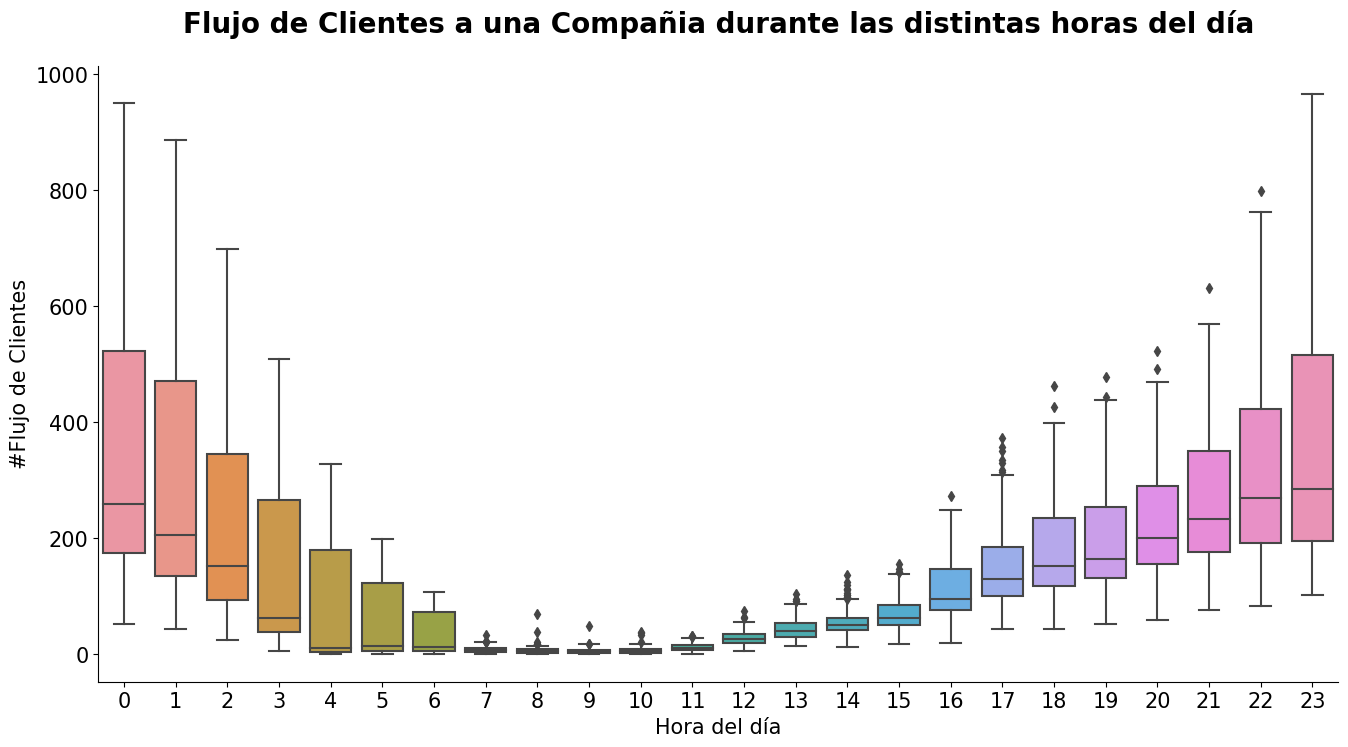

In [27]:
def hide_border(ax):
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(16,8))
seaborn.boxplot(df_group3_order.Hora,df_group3_order.Cantidad,ax=ax)
ax.set_xlabel("Hora del día",fontsize=15)
ax.set_ylabel("#Flujo de Clientes",fontsize=15)
plt.setp(ax.get_xticklabels(),fontsize=15)
plt.yticks(fontsize=15)
ax.set_title("Flujo de Clientes a una Compañia durante las distintas horas del día",pad=24,fontweight=700,fontsize=20)
hide_border(ax)

Del gráfico superior se pueden tomar algunas conclusiones:

1. Hay horas del día en las que hay un uso masivo de máquinas en comparación con otras, lo que había sido observado en el gráfico anterior, aunque distorsionado porque ahora sabemos que la mediana y la media están distanciadas debido a la presencia de valores extremos, especialmente en las horas de alto uso.

2. Evidentemente, las primeras horas de la mañana es cuando menos uso hay y, recíprocamente, al comenzar la tarde y entrada la noche es cuando se produce el máximo de uso.

3. Esta visualización de los datos (_boxplot_) agrega valor en el sentido que aporta granularidad al análisis que se pretende hacer y las conclusiones que se puedan sacar de este análisis en un futuro.

###  Plot Semana Promedio

Veamos ahora que sucede cuando vemos el promedio de Flujo de Clientes ahora a nivel de los distintos días de la semana. Para eso generemos un _dataframe_ que indique promedio de sesiones (uso) para cada hora del dia, los siete dias de la semana.

In [28]:
semana_promedio=df_group3_order.groupby(['Hora','Dia'])['Cantidad'].mean().reset_index()
semana_promedio=semana_promedio.sort_values(by=['Dia','Hora']).reset_index(drop=True)
semana_promedio



,Hora,Dia,Cantidad
0,0,1,139.166667
1,1,1,120.416667
2,2,1,87.470588
3,3,1,39.685714
4,4,1,12.192308
...,...,...,...
163,19,7,250.657143
164,20,7,261.371429
165,21,7,253.742857
166,22,7,250.600000


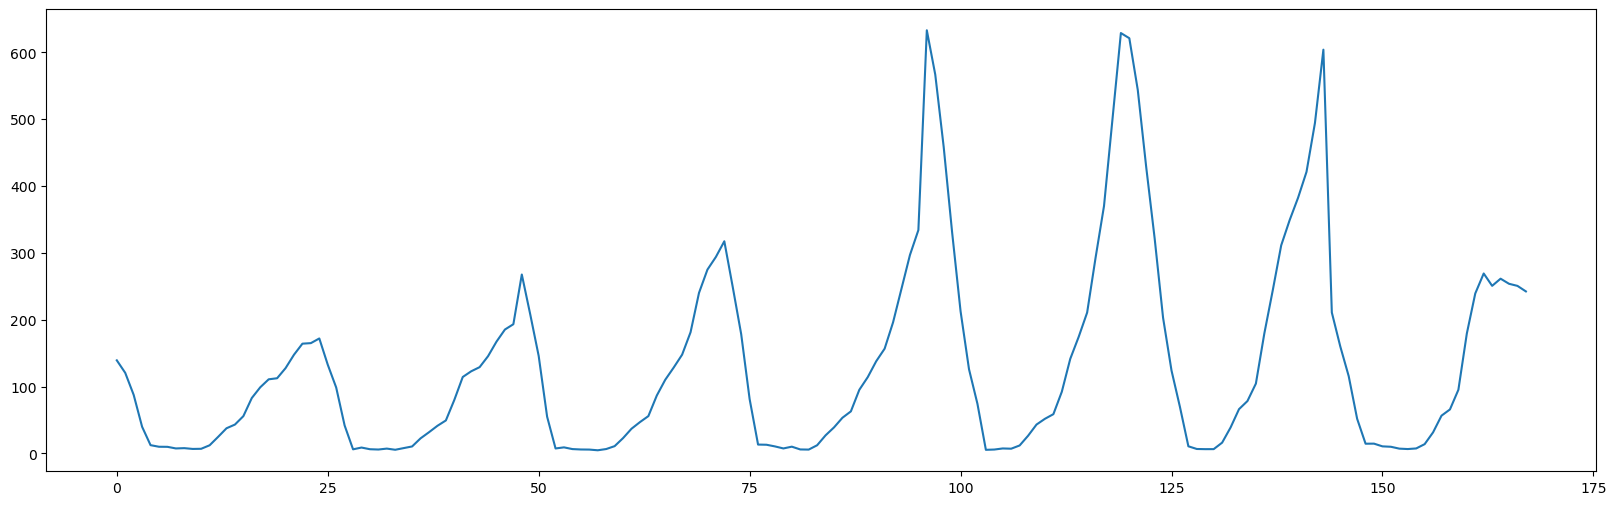

In [29]:
plt.figure(figsize=(20, 6))
plt.plot(semana_promedio['Cantidad'])

Al igual que el caso anterior, este set de datos nos muestra tendencia pero, por el hecho de graficar promedios, nos esconde datos que pueden ser interesantes para investigar. Por ejemplo, cuanta dispersión hay en los distintos días de la semana. Volvamos al _df_ original y grafiquemos en _boxplot_ según día de la semana.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


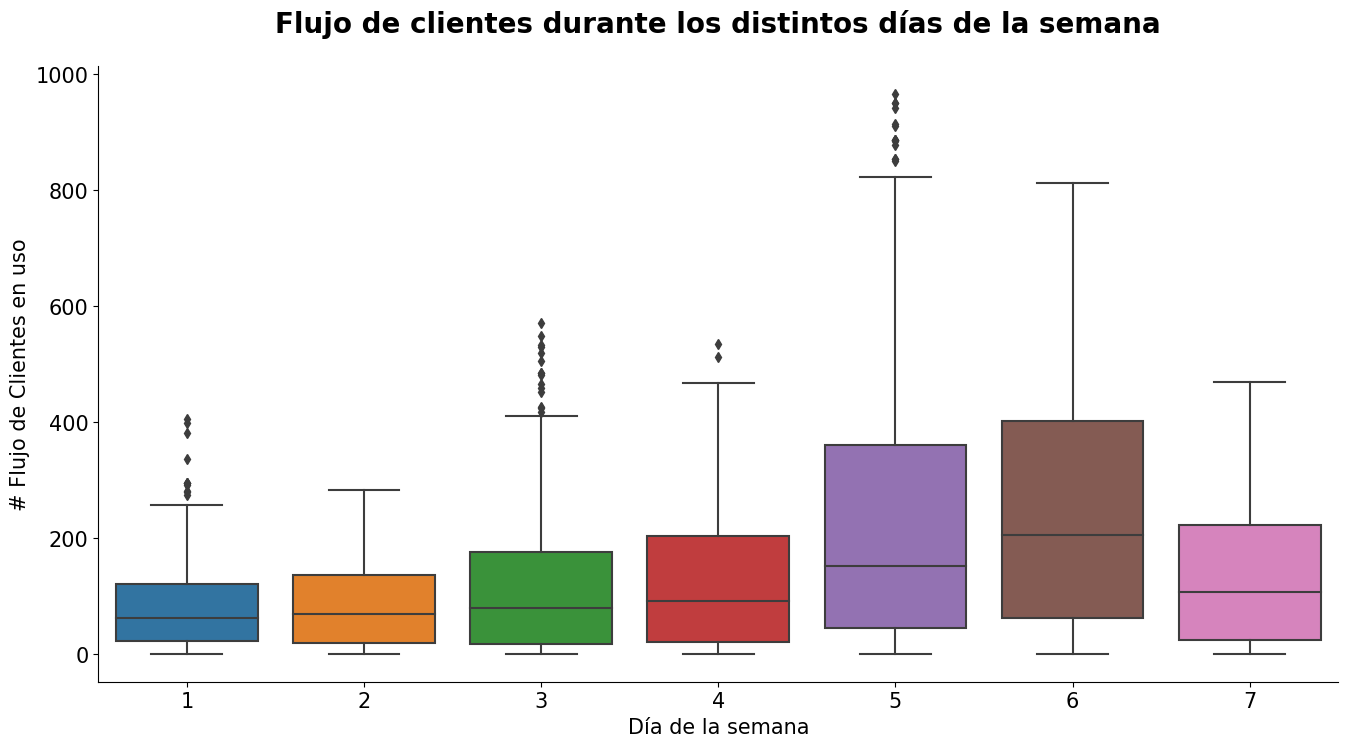

In [30]:
def hide_border(ax):
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(16,8))
seaborn.boxplot(df_group3_order.Dia,df_group3_order.Cantidad,ax=ax)
ax.set_xlabel("Día de la semana",fontsize=15)
ax.set_ylabel("# Flujo de Clientes en uso",fontsize=15)
plt.setp(ax.get_xticklabels(),fontsize=15)
plt.yticks(fontsize=15)
ax.set_title("Flujo de clientes durante los distintos días de la semana",pad=24,fontweight=700,fontsize=20)
hide_border(ax)

### Construcción de Atributos Estacionales

**Debido a la alta estacionalidad en dias fin de semana y probablemente los dias feriados y dias previos a feriado se construirán distintos atributos**

**1) Se construirá el atributo FDS, que en rigor serán los dias Jueves, Viernes y Sabado**

In [31]:
df_group3_order['FDS'] = np.where((df_group3_order['Dia'] == 4)|(df_group3_order['Dia'] == 5)|(df_group3_order['Dia'] == 6), 1, 0)
df_group3_order.head()

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime,FDS
0,0,6,1,01-01-2022,1,620,0:00:00,2022-01-01,2022-01-01 00:00:00,1
1,1,6,1,01-01-2022,1,566,1:00:00,2022-01-01,2022-01-01 01:00:00,1
2,2,6,1,01-01-2022,1,472,2:00:00,2022-01-01,2022-01-01 02:00:00,1
3,3,6,1,01-01-2022,1,369,3:00:00,2022-01-01,2022-01-01 03:00:00,1
4,4,6,1,01-01-2022,1,247,4:00:00,2022-01-01,2022-01-01 04:00:00,1


In [32]:
fds_promedio=df_group3_order.groupby(['FDS'])['Cantidad'].mean().reset_index()
fds_promedio

,FDS,Cantidad
0,0,100.985963
1,1,200.921585


In [33]:
stats.ttest_ind(df_group3_order['Cantidad'][df_group3_order['FDS'] == 0],
                df_group3_order['Cantidad'][df_group3_order['FDS'] == 1],
                equal_var=False,alternative="less")


Ttest_indResult(statistic=-22.93409553682203, pvalue=2.6658360250518903e-108)

A pesar de que la tendencia es clara al comparar los promedios, quisimos aplicar un test estadístico de manera de corroborar lo esperado. Como de antemano se intuía y se visualizaba que los fines de semana se usaban mucho más intensamente las máquinas que durante la semana, utilizamos los parámetros correspondientes. En definitiva, la diferencia entre el uso de máquinas es significativa, con un _p-value_ de 2.66 e-108.

**2) Se construirá el atributo feriado, que en rigor considerará el dia feriado y el dia anterior al feriado**

In [34]:
df_group3_order['feriado'] = df_group3_order['datetime'].apply(lambda f:Feriado(f))
df_group3_order['feriado2'] = np.where((df_group3_order['feriado'] == True), 1, 0)    

In [35]:
df_group3_order['antesdeferiado'] = df_group3_order['datetime'].apply(lambda f: Diaantesdeferiado(f) )
df_group3_order['antesdeferiado2'] = np.where((df_group3_order['antesdeferiado'] == True),1,0)
df_group3_order['feriado_final'] = np.where((df_group3_order['antesdeferiado2'] == 1)|(df_group3_order['feriado2'] == 1),1,0)
df_group3_order.drop(['feriado', 'antesdeferiado'], axis=1)

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime,FDS,feriado2,antesdeferiado2,feriado_final
0,0,6,1,01-01-2022,1,620,0:00:00,2022-01-01,2022-01-01 00:00:00,1,1,0,1
1,1,6,1,01-01-2022,1,566,1:00:00,2022-01-01,2022-01-01 01:00:00,1,1,0,1
2,2,6,1,01-01-2022,1,472,2:00:00,2022-01-01,2022-01-01 02:00:00,1,1,0,1
3,3,6,1,01-01-2022,1,369,3:00:00,2022-01-01,2022-01-01 03:00:00,1,1,0,1
4,4,6,1,01-01-2022,1,247,4:00:00,2022-01-01,2022-01-01 04:00:00,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,19,1,38,12-09-2022,9,56,19:00:00,2022-09-12,2022-12-09 19:00:00,0,0,0,0
5360,20,1,38,12-09-2022,9,108,20:00:00,2022-09-12,2022-12-09 20:00:00,0,0,0,0
5361,21,1,38,12-09-2022,9,126,21:00:00,2022-09-12,2022-12-09 21:00:00,0,0,0,0
5362,22,1,38,12-09-2022,9,169,22:00:00,2022-09-12,2022-12-09 22:00:00,0,0,0,0


In [36]:
feriado_final_promedio=df_group3_order.groupby(['feriado_final'])['Cantidad'].mean().reset_index()
feriado_final_promedio

,feriado_final,Cantidad
0,0,140.825227
1,1,197.914425


In [37]:
stats.ttest_ind(df_group3_order['Cantidad'][df_group3_order['feriado_final'] == 0],
                df_group3_order['Cantidad'][df_group3_order['feriado_final'] == 1],
                equal_var=False,alternative="less")


Ttest_indResult(statistic=-5.848003360653461, pvalue=4.784021573849017e-09)

Del mismo modo, al estudiar el "efecto víspera de feriado", es decir, cuanto afecta en el uso de máquinas el hecho de que al día siguiente haya un feriado, la diferencia también es significativa. En este caso, el _p-value_ es de 1,14e-10

**3) Se creará el atributo periodo del dia, el cual será una clasificación segun rango horario:**
- Madrugada
- Mañana
- Noche
- Tarde

In [38]:
conditions=[ (df_group3_order['Hora']<=4),
             (df_group3_order['Hora']>4) & (df_group3_order['Hora']<=11),
             (df_group3_order['Hora']>11) & (df_group3_order['Hora']<=17),
             (df_group3_order['Hora']>17)    
            ]

In [39]:
choices=['Madrugada','Mañana','Tarde','Noche']

In [40]:
df_group3_order['rango_hora'] =np.select(conditions,choices)
df_group3_order.head()

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime,FDS,feriado,feriado2,antesdeferiado,antesdeferiado2,feriado_final,rango_hora
0,0,6,1,01-01-2022,1,620,0:00:00,2022-01-01,2022-01-01 00:00:00,1,True,1,0,0,1,Madrugada
1,1,6,1,01-01-2022,1,566,1:00:00,2022-01-01,2022-01-01 01:00:00,1,True,1,0,0,1,Madrugada
2,2,6,1,01-01-2022,1,472,2:00:00,2022-01-01,2022-01-01 02:00:00,1,True,1,0,0,1,Madrugada
3,3,6,1,01-01-2022,1,369,3:00:00,2022-01-01,2022-01-01 03:00:00,1,True,1,0,0,1,Madrugada
4,4,6,1,01-01-2022,1,247,4:00:00,2022-01-01,2022-01-01 04:00:00,1,True,1,0,0,1,Madrugada


In [41]:
rango_hora_promedio=df_group3_order.groupby(['rango_hora'])['Cantidad'].mean().reset_index()
rango_hora_promedio

,rango_hora,Cantidad
0,Madrugada,212.272951
1,Mañana,20.145870
2,Noche,253.967399
3,Tarde,76.596141


In [42]:
f_oneway(df_group3_order['Cantidad'][df_group3_order['rango_hora'] == "Madrugada"],
         df_group3_order['Cantidad'][df_group3_order['rango_hora'] == "Mañana"],
         df_group3_order['Cantidad'][df_group3_order['rango_hora'] == "Tarde"],
         df_group3_order['Cantidad'][df_group3_order['rango_hora'] == "Noche"])

F_onewayResult(statistic=1052.2515489623668, pvalue=0.0)

En este caso, llamativamente, los promedios son muy distintos para los distintos segmentos del día. Por esto, al realizar un test de ANOVA de una vía para comparar, da un _p-value_ de cero, lo que se puede interpretar como que es virtualmente imposible encontrar esta distribución de datos bajo la hipótesis nula de que los promedios de grupos son iguales.

In [43]:
df_group3_order['date'] = pd.to_datetime(df_group3_order['date'])

In [44]:
df_group3_order['semana_del_mes'] = semana_del_mes(df_group3_order['date'])

0 [0, 0, 0, 0, 0, 1, 2]
1 [3, 4, 5, 6, 7, 8, 9]
2 [10, 11, 12, 13, 14, 15, 16]
3 [17, 18, 19, 20, 21, 22, 23]
4 [24, 25, 26, 27, 28, 29, 30]
5 [31, 0, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 1, 2]
1 [3, 4, 5, 6, 7, 8, 9]
2 [10, 11, 12, 13, 14, 15, 16]
3 [17, 18, 19, 20, 21, 22, 23]
4 [24, 25, 26, 27, 28, 29, 30]
5 [31, 0, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 1, 2]
1 [3, 4, 5, 6, 7, 8, 9]
2 [10, 11, 12, 13, 14, 15, 16]
3 [17, 18, 19, 20, 21, 22, 23]
4 [24, 25, 26, 27, 28, 29, 30]
5 [31, 0, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 1, 2]
1 [3, 4, 5, 6, 7, 8, 9]
2 [10, 11, 12, 13, 14, 15, 16]
3 [17, 18, 19, 20, 21, 22, 23]
4 [24, 25, 26, 27, 28, 29, 30]
5 [31, 0, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 1, 2]
1 [3, 4, 5, 6, 7, 8, 9]
2 [10, 11, 12, 13, 14, 15, 16]
3 [17, 18, 19, 20, 21, 22, 23]
4 [24, 25, 26, 27, 28, 29, 30]
5 [31, 0, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 1, 2]
1 [3, 4, 5, 6, 7, 8, 9]
2 [10, 11, 12, 13, 14, 15, 16]
3 [17, 18, 19, 20, 21, 22, 23]
4 [24, 25, 26, 27, 28, 29, 30]
5 [31, 0, 0, 0, 0, 0, 0]
0 [0

0 [1, 2, 3, 4, 5, 6, 7]
1 [8, 9, 10, 11, 12, 13, 14]
2 [15, 16, 17, 18, 19, 20, 21]
3 [22, 23, 24, 25, 26, 27, 28]
4 [29, 30, 31, 0, 0, 0, 0]
0 [1, 2, 3, 4, 5, 6, 7]
1 [8, 9, 10, 11, 12, 13, 14]
2 [15, 16, 17, 18, 19, 20, 21]
3 [22, 23, 24, 25, 26, 27, 28]
4 [29, 30, 31, 0, 0, 0, 0]
0 [1, 2, 3, 4, 5, 6, 7]
1 [8, 9, 10, 11, 12, 13, 14]
2 [15, 16, 17, 18, 19, 20, 21]
3 [22, 23, 24, 25, 26, 27, 28]
4 [29, 30, 31, 0, 0, 0, 0]
0 [1, 2, 3, 4, 5, 6, 7]
1 [8, 9, 10, 11, 12, 13, 14]
2 [15, 16, 17, 18, 19, 20, 21]
3 [22, 23, 24, 25, 26, 27, 28]
4 [29, 30, 31, 0, 0, 0, 0]
0 [1, 2, 3, 4, 5, 6, 7]
1 [8, 9, 10, 11, 12, 13, 14]
2 [15, 16, 17, 18, 19, 20, 21]
3 [22, 23, 24, 25, 26, 27, 28]
4 [29, 30, 31, 0, 0, 0, 0]
0 [1, 2, 3, 4, 5, 6, 7]
1 [8, 9, 10, 11, 12, 13, 14]
2 [15, 16, 17, 18, 19, 20, 21]
3 [22, 23, 24, 25, 26, 27, 28]
4 [29, 30, 31, 0, 0, 0, 0]
0 [1, 2, 3, 4, 5, 6, 7]
1 [8, 9, 10, 11, 12, 13, 14]
2 [15, 16, 17, 18, 19, 20, 21]
3 [22, 23, 24, 25, 26, 27, 28]
4 [29, 30, 31, 0, 0, 0, 0]
0 [1, 

0 [0, 0, 0, 0, 0, 0, 1]
1 [2, 3, 4, 5, 6, 7, 8]
2 [9, 10, 11, 12, 13, 14, 15]
3 [16, 17, 18, 19, 20, 21, 22]
4 [23, 24, 25, 26, 27, 28, 29]
5 [30, 31, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 0, 1]
1 [2, 3, 4, 5, 6, 7, 8]
2 [9, 10, 11, 12, 13, 14, 15]
3 [16, 17, 18, 19, 20, 21, 22]
4 [23, 24, 25, 26, 27, 28, 29]
5 [30, 31, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 0, 1]
1 [2, 3, 4, 5, 6, 7, 8]
2 [9, 10, 11, 12, 13, 14, 15]
3 [16, 17, 18, 19, 20, 21, 22]
4 [23, 24, 25, 26, 27, 28, 29]
5 [30, 31, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 0, 1]
1 [2, 3, 4, 5, 6, 7, 8]
2 [9, 10, 11, 12, 13, 14, 15]
3 [16, 17, 18, 19, 20, 21, 22]
4 [23, 24, 25, 26, 27, 28, 29]
5 [30, 31, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 0, 1]
1 [2, 3, 4, 5, 6, 7, 8]
2 [9, 10, 11, 12, 13, 14, 15]
3 [16, 17, 18, 19, 20, 21, 22]
4 [23, 24, 25, 26, 27, 28, 29]
5 [30, 31, 0, 0, 0, 0, 0]
0 [0, 0, 0, 0, 0, 0, 1]
1 [2, 3, 4, 5, 6, 7, 8]
2 [9, 10, 11, 12, 13, 14, 15]
3 [16, 17, 18, 19, 20, 21, 22]
4 [23, 24, 25, 26, 27, 28, 29]
5 [30, 31, 0, 0, 0, 0, 0]
0 [0

In [45]:
df_group3_order

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime,FDS,feriado,feriado2,antesdeferiado,antesdeferiado2,feriado_final,rango_hora,semana_del_mes
0,0,6,1,01-01-2022,1,620,0:00:00,2022-01-01,2022-01-01 00:00:00,1,True,1,0,0,1,Madrugada,Primera
1,1,6,1,01-01-2022,1,566,1:00:00,2022-01-01,2022-01-01 01:00:00,1,True,1,0,0,1,Madrugada,Primera
2,2,6,1,01-01-2022,1,472,2:00:00,2022-01-01,2022-01-01 02:00:00,1,True,1,0,0,1,Madrugada,Primera
3,3,6,1,01-01-2022,1,369,3:00:00,2022-01-01,2022-01-01 03:00:00,1,True,1,0,0,1,Madrugada,Primera
4,4,6,1,01-01-2022,1,247,4:00:00,2022-01-01,2022-01-01 04:00:00,1,True,1,0,0,1,Madrugada,Primera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,19,1,38,12-09-2022,9,56,19:00:00,2022-09-12,2022-12-09 19:00:00,0,False,0,0,0,0,Noche,Intermedia
5360,20,1,38,12-09-2022,9,108,20:00:00,2022-09-12,2022-12-09 20:00:00,0,False,0,0,0,0,Noche,Intermedia
5361,21,1,38,12-09-2022,9,126,21:00:00,2022-09-12,2022-12-09 21:00:00,0,False,0,0,0,0,Noche,Intermedia
5362,22,1,38,12-09-2022,9,169,22:00:00,2022-09-12,2022-12-09 22:00:00,0,False,0,0,0,0,Noche,Intermedia


In [46]:
semana_del_mes=df_group3_order.groupby(['semana_del_mes'])['Cantidad'].mean().reset_index()
semana_del_mes

,semana_del_mes,Cantidad
0,Intermedia,145.520159
1,Primera,160.462629
2,Ultima,121.959649


Interesantemente, aquí el análisis que estamos haciendo tiene que ver con la presunción de que el gasto del cliente está directamente asociado al momento en que recibe el sueldo. Generalmente en Chile esto sucede a principios de mes o bien a principios de mes y en la mitad del mes (pago "por quincena"). De todos modos, lo que está en juego aquí es verificar que el gasto en entretenimiento (asociado a máquinas Flujo de Clientes, en este caso) es mayor en el momento más cercano a que los clientes reciban su sueldo. Verifiquemos si estas diferencias son estadísticamente significativas:

In [47]:
f_oneway(df_group3_order['Cantidad'][df_group3_order['semana_del_mes'] == "Primera"],
         df_group3_order['Cantidad'][df_group3_order['semana_del_mes'] == "Intermedia"],
         df_group3_order['Cantidad'][df_group3_order['semana_del_mes'] == "Ultima"],
         )

F_onewayResult(statistic=10.131190203560886, pvalue=4.058579463249774e-05)

A pesar que los promedios son cercanos, un test de ANOVA de una vía indica que hay diferencias significativas en el flujo de clientes en las distintas semanas del mes, lo que _a priori_ corrobora la hipótesis planteada, con un _p-value_ de 4,06e-05.

**Se implementará un caso de negocio donde se va a predecir el proximo dia completo, esto quiere decir las proximas 24 horas o los proximos 24 registros. Por lo tanto truncaremos el dataset con el registro del penultimo dia**

In [48]:
df_group3_order=df_group3_order[df_group3_order['datetime']<'2022-09-11']
df_group3_order

,Hora,Dia,Semana,Fecha,Mes,Cantidad,time,date,datetime,FDS,feriado,feriado2,antesdeferiado,antesdeferiado2,feriado_final,rango_hora,semana_del_mes
0,0,6,1,01-01-2022,1,620,0:00:00,2022-01-01,2022-01-01 00:00:00,1,True,1,0,0,1,Madrugada,Primera
1,1,6,1,01-01-2022,1,566,1:00:00,2022-01-01,2022-01-01 01:00:00,1,True,1,0,0,1,Madrugada,Primera
2,2,6,1,01-01-2022,1,472,2:00:00,2022-01-01,2022-01-01 02:00:00,1,True,1,0,0,1,Madrugada,Primera
3,3,6,1,01-01-2022,1,369,3:00:00,2022-01-01,2022-01-01 03:00:00,1,True,1,0,0,1,Madrugada,Primera
4,4,6,1,01-01-2022,1,247,4:00:00,2022-01-01,2022-01-01 04:00:00,1,True,1,0,0,1,Madrugada,Primera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782,19,5,37,09-09-2022,9,84,19:00:00,2022-09-09,2022-09-09 19:00:00,1,False,0,0,0,0,Noche,Intermedia
4783,20,5,37,09-09-2022,9,269,20:00:00,2022-09-09,2022-09-09 20:00:00,1,False,0,0,0,0,Noche,Intermedia
4784,21,5,37,09-09-2022,9,356,21:00:00,2022-09-09,2022-09-09 21:00:00,1,False,0,0,0,0,Noche,Intermedia
4785,22,5,37,09-09-2022,9,486,22:00:00,2022-09-09,2022-09-09 22:00:00,1,False,0,0,0,0,Noche,Intermedia


### Completitud Serie de Tiempo

**Ahora evaluaremos la completitud de la serie de tiempo para esto crearemos un intervalo de tiempo**

In [49]:
datelist = pd.date_range(start='2022-01-01 00:00:00',end='2022-09-10 23:00:00', freq='h').tolist()
len(datelist)


6072

**Se observa que existe una diferencia entre la cantidad de registros del intervalo de tiempo real de 6072 y nuestra serie de tiempo tiene 5349 registros, eso es muy plausible debido a que hay horario de mañana donde la tienda puede cerrar**

In [50]:
df_zero=pd.DataFrame(datelist, columns=['datetime'])

In [51]:
df_zero['Cantidad']=0
df_zero

,datetime,Cantidad
0,2022-01-01 00:00:00,0
1,2022-01-01 01:00:00,0
2,2022-01-01 02:00:00,0
3,2022-01-01 03:00:00,0
4,2022-01-01 04:00:00,0
...,...,...
6067,2022-09-10 19:00:00,0
6068,2022-09-10 20:00:00,0
6069,2022-09-10 21:00:00,0
6070,2022-09-10 22:00:00,0


In [52]:
df_serie_tiempo=df_group3_order[['datetime','Cantidad']]
df_serie_tiempo

,datetime,Cantidad
0,2022-01-01 00:00:00,620
1,2022-01-01 01:00:00,566
2,2022-01-01 02:00:00,472
3,2022-01-01 03:00:00,369
4,2022-01-01 04:00:00,247
...,...,...
4782,2022-09-09 19:00:00,84
4783,2022-09-09 20:00:00,269
4784,2022-09-09 21:00:00,356
4785,2022-09-09 22:00:00,486


In [53]:
df_completitud=pd.concat([df_zero, df_serie_tiempo])
df_completitud

,datetime,Cantidad
0,2022-01-01 00:00:00,0
1,2022-01-01 01:00:00,0
2,2022-01-01 02:00:00,0
3,2022-01-01 03:00:00,0
4,2022-01-01 04:00:00,0
...,...,...
4782,2022-09-09 19:00:00,84
4783,2022-09-09 20:00:00,269
4784,2022-09-09 21:00:00,356
4785,2022-09-09 22:00:00,486


**Luego de concatenar ambos dataframe seleccionaremos el registro mayor para cada timestamp de manera de conservar la serie de tiempo original y agregar una matriz de ceros aquellos registros que no tenian datos en la serie de tiempo original**

In [54]:
df_arima=df_completitud.groupby(['datetime'])['Cantidad'].max().reset_index()
df_arima

,datetime,Cantidad
0,2022-01-01 00:00:00,620
1,2022-01-01 01:00:00,566
2,2022-01-01 02:00:00,472
3,2022-01-01 03:00:00,369
4,2022-01-01 04:00:00,247
...,...,...
6067,2022-09-10 19:00:00,0
6068,2022-09-10 20:00:00,0
6069,2022-09-10 21:00:00,0
6070,2022-09-10 22:00:00,0


In [55]:
df_arima.to_csv('Data/processed/datos_modelo.csv', index=False)